# Testing Snowplow Algorithm

In [13]:
import os
# switch directories for import
os.chdir('c:\\Users\\Sneez\\Desktop\\Snowplowing\\Snowplow-Routing-Middleton\\Snowplow-Routing-Middleton')

import initialize
import dual_graphs
import pandas as pd
import construction
from local_search import local_improve
from shortest_paths import ShortestPaths
from crossover import apply_crossover
from genetic import run_genetic
import plotting
from costs import routes_cost
from solution import Solution
from params import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autoreload documentation: https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html

For reloading user modules

In [2]:
toyEdgeFile = "C:\\Users\\Sneez\\Desktop\\Snowplowing\\Snowplow-Routing-Middleton\\Snowplow-Routing-Middleton\\graph_data\\edges.csv"
toyNodeFile = "C:\\Users\\Sneez\\Desktop\\Snowplowing\\Snowplow-Routing-Middleton\\Snowplow-Routing-Middleton\\graph_data\\nodes.csv"

In [3]:
instance = "smalltoy"

match instance:
    case "smallstreets":
        G = initialize.create_small_streets()
    case "fullstreets":
        G = initialize.create_full_streets()
    case "smalltoy":
        G = initialize.create_small_toy(toyEdgeFile, toyNodeFile)
    case _:
        print("Invalid instance name")
        
approach = "genetic"

if approach == "genetic":
    G = initialize.add_multi_edges(G)
    if instance == "smallstreets" or instance == "fullstreets":
        G_DUAL = dual_graphs.create_dual_streets(G)
    else:
        G_DUAL = dual_graphs.create_dual_toy(G)

elif approach == "annealing":
    if instance == "smallstreets" or instance == "fullstreets":
        G_DUAL = dual_graphs.create_dual_streets(G, False, True)
    else:
        G_DUAL = dual_graphs.create_dual_toy(G, False, True)



In [4]:
print(G_DUAL)

MultiDiGraph with 15 nodes and 50 edges


In [5]:
sp = ShortestPaths(G_DUAL, False, False)

In [6]:
construction.process_node(G, 0, 1)

([(1,
   2,
   0,
   {'distance': 1,
    'priority': 1,
    'travel_time': 2,
    'passes_rem': 1,
    'salt_per': 1,
    'deadheading_passes': 0,
    'serviced': False}),
  (1,
   2,
   1,
   {'distance': 1,
    'priority': 3,
    'travel_time': 1,
    'passes_rem': 2,
    'salt_per': 1,
    'deadheading_passes': 0,
    'serviced': False}),
  (1,
   4,
   0,
   {'distance': 2,
    'priority': 2,
    'travel_time': 2,
    'passes_rem': 1,
    'salt_per': 1,
    'deadheading_passes': 0,
    'serviced': False})],
 3,
 4)

In [9]:
r, rreq = construction.route_generation(G, sp)

In [16]:
for route in rreq:
    for step in route:
        print(step)

0 --> 2. (0) Deadhead: False. Had options: False. Salt value: 100
2 --> 1. (0) Deadhead: False. Had options: True. Salt value: 99
1 --> 4. (0) Deadhead: False. Had options: True. Salt value: 98
4 --> 1. (0) Deadhead: False. Had options: True. Salt value: 97
1 --> 2. (1) Deadhead: False. Had options: True. Salt value: 96
2 --> 1. (1) Deadhead: False. Had options: True. Salt value: 95
1 --> 2. (0) Deadhead: False. Had options: True. Salt value: 94
2 --> 0. (0) Deadhead: False. Had options: True. Salt value: 93
2 --> 3. (1) Deadhead: False. Had options: True. Salt value: 100
3 --> 2. (0) Deadhead: False. Had options: True. Salt value: 99
2 --> 3. (0) Deadhead: False. Had options: True. Salt value: 98
3 --> 2. (1) Deadhead: False. Had options: True. Salt value: 97
3 --> 4. (0) Deadhead: False. Had options: True. Salt value: 96
4 --> 3. (0) Deadhead: False. Had options: True. Salt value: 95


In [14]:
new_sol = Solution(rreq, dict(), routes_cost(G, sp, rreq), 0)

required_edges = set(edge[:3] for edge in G.edges(data=True, keys=True) if edge[3]['priority'] != 0)
nearest_neighbors = sp.compute_nearest_neighbors()

new_sol = local_improve(new_sol, G, sp, nearest_neighbors, required_edges, K)

In [15]:
for route in new_sol.routes:
    for step in route:
        print(step)

3 --> 2. (1) Deadhead: False. Had options: True. Salt value: 97
2 --> 1. (1) Deadhead: False. Had options: True. Salt value: 95
1 --> 4. (0) Deadhead: False. Had options: True. Salt value: 98
4 --> 1. (0) Deadhead: False. Had options: True. Salt value: 97
1 --> 2. (1) Deadhead: False. Had options: True. Salt value: 96
2 --> 0. (0) Deadhead: False. Had options: True. Salt value: 93
2 --> 3. (1) Deadhead: False. Had options: True. Salt value: 100
3 --> 2. (0) Deadhead: False. Had options: True. Salt value: 99
2 --> 1. (0) Deadhead: False. Had options: True. Salt value: 99
3 --> 4. (0) Deadhead: False. Had options: True. Salt value: 96
4 --> 3. (0) Deadhead: False. Had options: True. Salt value: 95
0 --> 2. (0) Deadhead: False. Had options: False. Salt value: 100
2 --> 3. (0) Deadhead: False. Had options: True. Salt value: 98
1 --> 2. (0) Deadhead: False. Had options: True. Salt value: 94


initial generation 0
initial generation 1
initial generation 2
initial generation 3
initial generation 4
initial generation 5
initial generation 6
initial generation 7
initial generation 8
initial generation 9
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
1 --> 2. (1) Deadhead: False. Had options: True. Salt value: 98
2 --> 3. (1) Deadhead: False. Had options: True. Salt value: 96
3 --> 2. (1) Deadhead: False. Had options: False. Salt value: 0
2 --> 1. (1) Deadhead: False. Had options: False. Salt value: 0
1 --> 4. (0) Deadhead: False. Had options: False. Salt value: 0
4 --> 3. (0) Deadhead: False. Had options: False. Salt value: 0
3 --> 4. (0) Deadhead: False. Had options: False. Salt value: 0
4 --> 1. (0) Deadhead: Fals

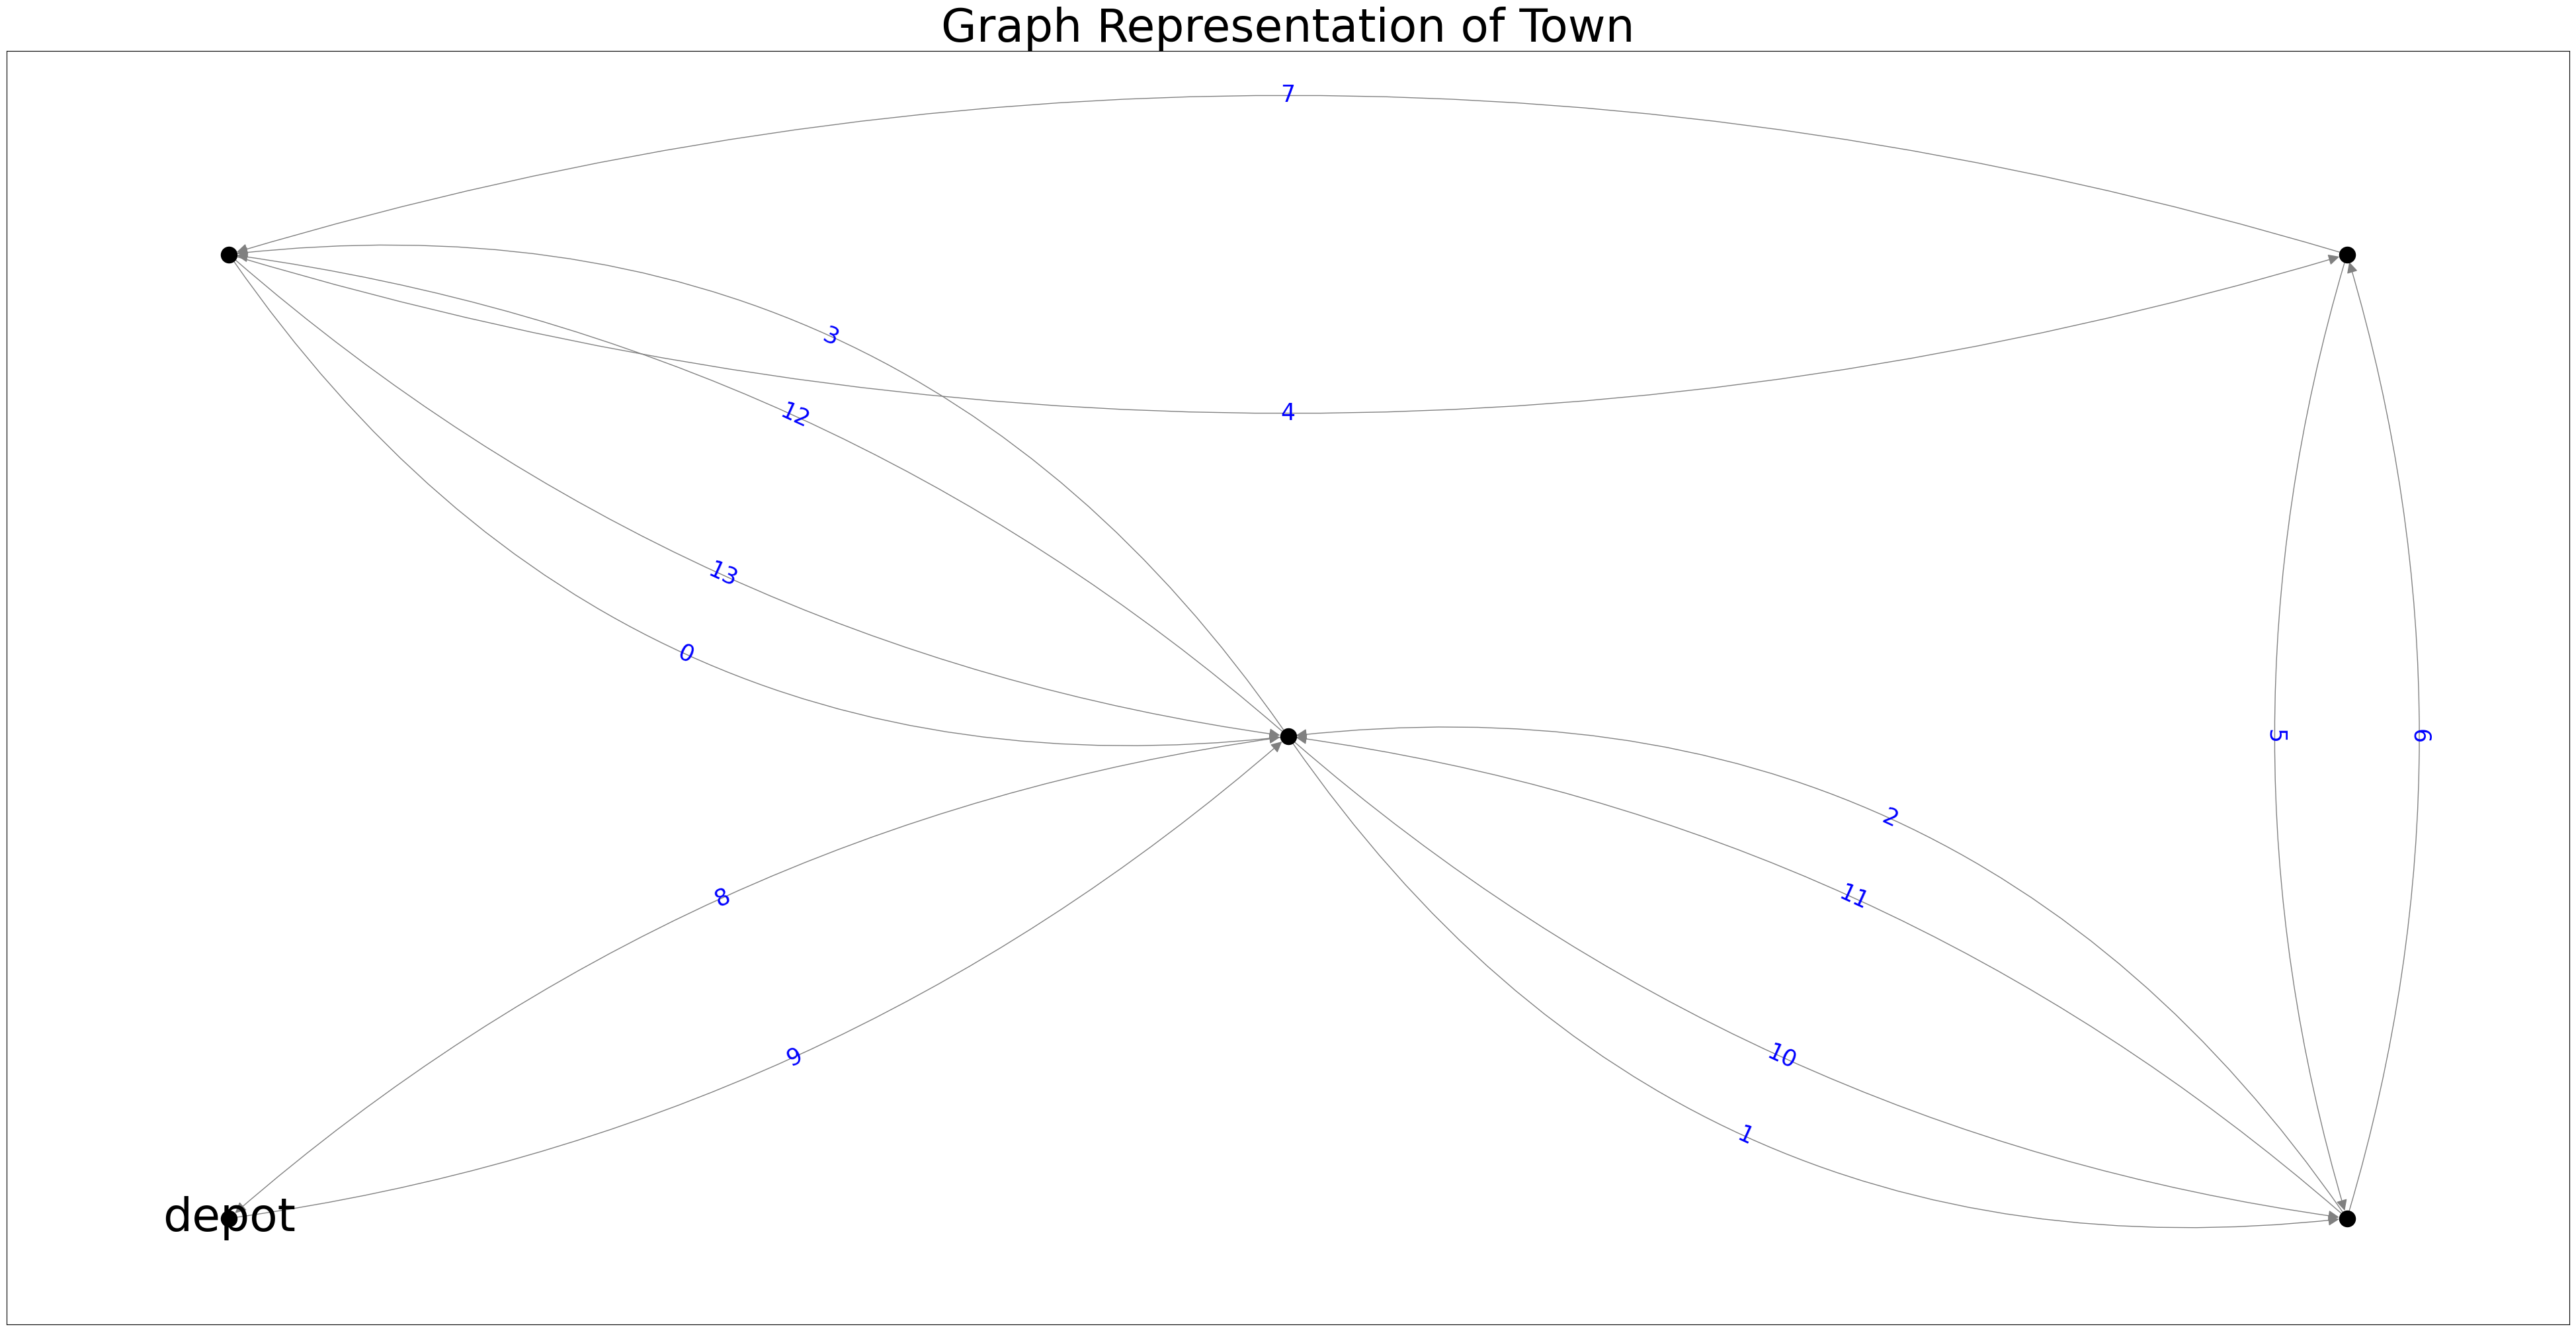

DONE
Routes cost 108.0


In [8]:
# 4. Route Improvement Algorithms
sol = run_genetic(G, sp)

for route in sol.routes:
    for edge in route:
        print(edge)
    print("***")


# 5. Plot final routes
G_graph = plotting.add_order_attribute(G, sol.routes)
plotting.draw_labeled_multigraph(G_graph, 'order', size=(50,25))

print("DONE")
print("Routes cost", sol.cost)